In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, auc
from torch.utils.data import DataLoader, Dataset


In [50]:
# making a completely different dataest.
class customCIFAR10(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transform)
        self.classes_of_interest = [4, 7]  # "Deer" (class 4) and "Horse" (class 7)
        
        # Filter out data that does not belong to these two classes
        self.filtered_data = []
        self.filtered_labels = []
        
        for i in range(len(self.dataset)):
            image, label = self.dataset[i]
            if label in self.classes_of_interest:
                self.filtered_data.append(image)
                self.filtered_labels.append(1 if label == 7 else 0)  # Map "Horse" to 1, "Deer" to 0

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, index):
        return self.filtered_data[index], self.filtered_labels[index]

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with CIFAR-10's mean and std
])


train_dataset = customCIFAR10(root='./data', train=True, transform=transform)
test_dataset = customCIFAR10(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.019607902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.96862745].


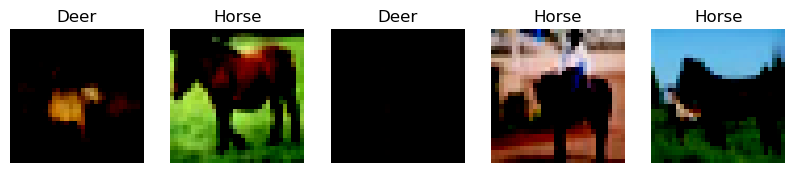

In [7]:

#horse is class 7 and deer is class 4. so filtering the data out as only working on these two classes
def filter_classes(dataset, classes):
    images, labels = [], []
    for img, label in dataset:
        if label in classes:
            images.append(img.numpy())  # Do not flatten here
            labels.append(1 if label == 4 else -1)  # Deer: 1, Horse: -1
    return np.array(images), np.array(labels)

X_train, y_train = filter_classes(trainset, [4, 7])
X_test, y_test = filter_classes(testset, [4, 7])

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    img = np.transpose(X_train[i], (1, 2, 0))  # Convert (3, 32, 32) to (32, 32, 3)
    plt.imshow(img)
    plt.title("Deer" if y_train[i] == 1 else "Horse")
    plt.axis('off')
plt.show()

#NOTE: apparently these images are normalized, so the pxiels are very weird, to see the images properly proabably gonna denormalize it.

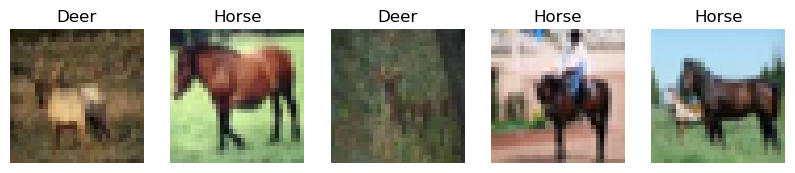

In [8]:
#Decided to denormalize the image to see them more properly. 
def denormalize(img):
    img = img * 0.5 + 0.5 #This is the formula that I used to denormalize them. img = img * std + mean, where std is 0.5 and so is the mean.
    img = np.clip(img, 0, 1) 
    return img

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    img = np.transpose(X_train[i], (1, 2, 0))
    img = denormalize(img)
    plt.imshow(img)
    plt.title("Deer" if y_train[i] == 1 else "Horse")
    plt.axis('off')
plt.show()


In [42]:
from torch import nn, optim

#trying out pca from here

pca_2 = PCA(n_components=2) 
X_train_pca_2 = pca_2.fit_transform(X_train.reshape(len(X_train), -1))
X_test_pca_2 = pca_2.transform(X_test.reshape(len(X_test), -1)) 


pca_100 = PCA(n_components=100)
X_train_pca_100 = pca_100.fit_transform(X_train.reshape(len(X_train), -1))  
X_test_pca_100 = pca_100.transform(X_test.reshape(len(X_test), -1)) 


class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

#nitializing the neural network
input_size = 100  #this should be equal to our n component since its the input layer of our neural netowk.
hidden_size = 64
output_size = 1 

model = FNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)

# converting data to tensor - fancy way of saying arrays :D
X_train_tensor = torch.FloatTensor(X_train_pca_100)
y_train_tensor = torch.FloatTensor((y_train + 1) / 2).view(-1, 1)  #normalizing them as [0,1] THIS THING RIGHT HERE GAVE ME ERROR CAUSE I WAS DOING 1,-1

y_test_tensor = torch.FloatTensor((y_test + 1) / 2).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_pca_100)

#Training neural network.
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'epoch [{epoch+1}/100], loss- {loss.item():.4f}') #just taking 4 decimal places.



epoch [1/100], loss- 0.7269
epoch [11/100], loss- 0.4528
epoch [21/100], loss- 0.3673
epoch [31/100], loss- 0.2922
epoch [41/100], loss- 0.2253
epoch [51/100], loss- 0.1672
epoch [61/100], loss- 0.1189
epoch [71/100], loss- 0.0818
epoch [81/100], loss- 0.0551
epoch [91/100], loss- 0.0367


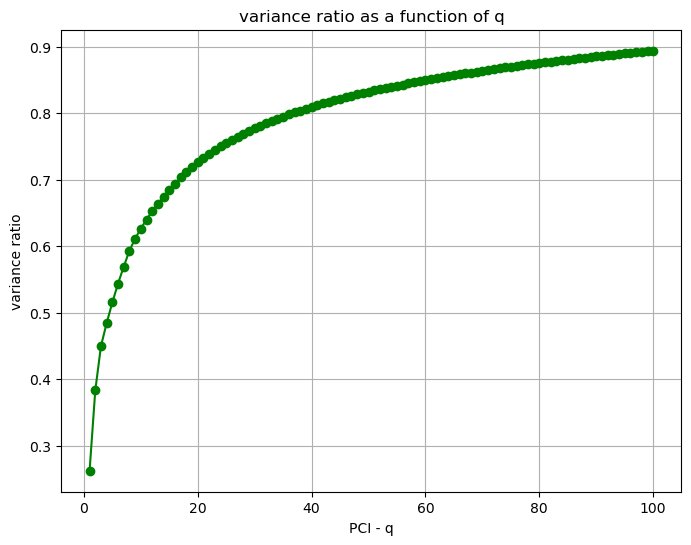

In [58]:
pca_100 = PCA(n_components=100)
pca_100.fit(X_train.reshape(len(X_train), -1))

explained_variance_ratio = pca_100.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='green')
plt.xlabel('PCI - q')
plt.ylabel('variance ratio')
plt.title('variance ratio as a function of q')
plt.grid(True)
plt.show()


In [59]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#initializing the model like always.
FFnet = Net(input_size=3072, hidden_size=1024, num_classes=2)  # Output for two classes: Horse and Deer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(FFnet.parameters(), lr=0.001, momentum=0.9)


max_epochs = 50
epoch_accuracy = np.zeros(max_epochs)

for epoch in range(max_epochs):
    batch_accuracy = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(images.size(0), -1)  # Flatten images for FFnet
        optimizer.zero_grad()
        y_pred = FFnet(images)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(y_pred, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        batch_accuracy.append(accuracy)

    epoch_accuracy[epoch] = np.mean(batch_accuracy)
    print(f"epoch- [{epoch+1}/{max_epochs}], accuracy= {epoch_accuracy[epoch]:.4f}")




epoch- [1/50], accuracy= 0.6577
epoch- [2/50], accuracy= 0.7317
epoch- [3/50], accuracy= 0.7546
epoch- [4/50], accuracy= 0.7745
epoch- [5/50], accuracy= 0.7913
epoch- [6/50], accuracy= 0.8041
epoch- [7/50], accuracy= 0.8136
epoch- [8/50], accuracy= 0.8240
epoch- [9/50], accuracy= 0.8322
epoch- [10/50], accuracy= 0.8376
epoch- [11/50], accuracy= 0.8473
epoch- [12/50], accuracy= 0.8515
epoch- [13/50], accuracy= 0.8604
epoch- [14/50], accuracy= 0.8672
epoch- [15/50], accuracy= 0.8745
epoch- [16/50], accuracy= 0.8768
epoch- [17/50], accuracy= 0.8854
epoch- [18/50], accuracy= 0.8918
epoch- [19/50], accuracy= 0.8960
epoch- [20/50], accuracy= 0.8986
epoch- [21/50], accuracy= 0.9008
epoch- [22/50], accuracy= 0.9073
epoch- [23/50], accuracy= 0.9098
epoch- [24/50], accuracy= 0.9174
epoch- [25/50], accuracy= 0.9198
epoch- [26/50], accuracy= 0.9219
epoch- [27/50], accuracy= 0.9291
epoch- [28/50], accuracy= 0.9332
epoch- [29/50], accuracy= 0.9321
epoch- [30/50], accuracy= 0.9383
epoch- [31/50], acc

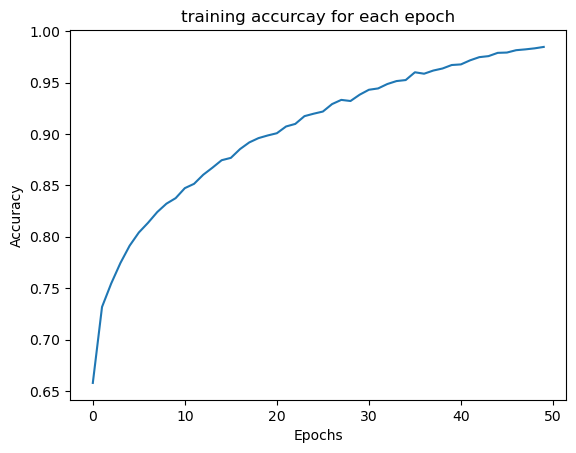

the accuracy on test set: 83.95%


In [68]:
plt.plot(np.arange(max_epochs), epoch_accuracy)
plt.title('training accurcay for each epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

#testing model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)  # Flatten for FFnet
        outputs = FFnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'the accuracy on test set: {accuracy}%')

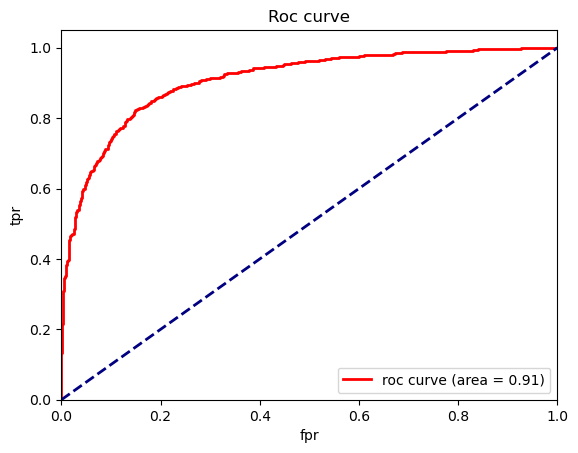

In [69]:
def plot_roc_curve(model, test_loader):
    model.eval()
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)  
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()  
            y_true.extend(labels.numpy())  #the true labels
            y_scores.extend(probs[:, 1])
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, label='roc curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('Roc curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(FFnet, test_loader)


In [73]:
def calculate_metrics(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = {0: 0, 1: 0}  # Class 0: Deer, Class 1: Horse
    class_total = {0: 0, 1: 0}
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)

            #for binary classification
            if outputs.size(1) == 2:
                outputs = outputs[:, 1]

            preds = torch.round(torch.sigmoid(outputs))

            total += labels.size(0)
            correct += (preds.squeeze() == labels).sum().item()

            for label, pred in zip(labels, preds.squeeze()):
                if label.item() == pred.item():
                    class_correct[label.item()] += 1
                class_total[label.item()] += 1
            y_true.extend(labels.numpy())
            y_scores.extend(torch.sigmoid(outputs).cpu().numpy()) 
    
    overall_accuracy = 100 * correct / total


    per_class_accuracy = {
        0: 100 * class_correct[0] / class_total[0] if class_total[0] > 0 else 0,
        1: 100 * class_correct[1] / class_total[1] if class_total[1] > 0 else 0
    }


    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    return overall_accuracy, per_class_accuracy, auc_score

overall_accuracy, per_class_accuracy, auc_score = calculate_metrics(FFnet, test_loader)


print("pfc and fnn")
print(f"our overall accuracy. {overall_accuracy:.2f}%")
print(f"horse accuracy {per_class_accuracy[1]:.2f}%")
print(f"deer accuracy {per_class_accuracy[0]:.2f}%")
print(f"auroc =  {auc_score:.4f}")


pfc and fnn
our overall accuracy. 83.50%
horse accuracy 83.00%
deer accuracy 84.00%
auroc =  0.9085


Starting the CNN now


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

#importing lib again. just in case.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #for faster computation. I have NVIDIA3050 :D

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified


In [6]:
def filter_classes(dataset, classes): #same function again.
    indices = [i for i, (_, label) in enumerate(dataset) if label in classes]
    dataset.data = dataset.data[indices]
    dataset.targets = [1 if dataset.targets[i] == 4 else -1 for i in indices]
    return dataset

trainset = filter_classes(trainset, [4, 7])
testset = filter_classes(testset, [4, 7])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

#starting CNN from here.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, optimizer, criterion, epochs=10): #starting here.
    model.train()
    train_acc = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), ((labels + 1) // 2).to(device)  # Convert -1,1 to 0,1
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct / total
        train_acc.append(acc)
        print(f'Epoch {epoch+1}, Accuracy: {acc:.4f}')
    return train_acc



In [7]:
learning_rates = [0.001, 0.0005, 0.0001] #for different variations
auroc_dict = {} #value gonna get added in this empty dict.
train_acc_dict = {}

for lr in learning_rates: #simple loop to run over the leraning rates list.
    model = CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    acc_history = train_model(model, optimizer, criterion)
    train_acc_dict[lr] = acc_history
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(((labels + 1) // 2).numpy())
    
    auroc = roc_auc_score(all_labels, all_preds)
    auroc_dict[lr] = auroc

#seeing the best hyperparameter now.
best_lr = max(auroc_dict, key=auroc_dict.get)
print(f'most optimal learning rate = {best_lr}, auroc accuracy = {auroc_dict[best_lr]:.4f}')



Epoch 1, Accuracy: 0.7507
Epoch 2, Accuracy: 0.8314
Epoch 3, Accuracy: 0.8707
Epoch 4, Accuracy: 0.8950
Epoch 5, Accuracy: 0.9120
Epoch 6, Accuracy: 0.9311
Epoch 7, Accuracy: 0.9524
Epoch 8, Accuracy: 0.9630
Epoch 9, Accuracy: 0.9760
Epoch 10, Accuracy: 0.9835
Epoch 1, Accuracy: 0.7379
Epoch 2, Accuracy: 0.8069
Epoch 3, Accuracy: 0.8428
Epoch 4, Accuracy: 0.8679
Epoch 5, Accuracy: 0.8808
Epoch 6, Accuracy: 0.9029
Epoch 7, Accuracy: 0.9139
Epoch 8, Accuracy: 0.9312
Epoch 9, Accuracy: 0.9415
Epoch 10, Accuracy: 0.9547
Epoch 1, Accuracy: 0.6761
Epoch 2, Accuracy: 0.7709
Epoch 3, Accuracy: 0.7871
Epoch 4, Accuracy: 0.7972
Epoch 5, Accuracy: 0.8123
Epoch 6, Accuracy: 0.8230
Epoch 7, Accuracy: 0.8361
Epoch 8, Accuracy: 0.8453
Epoch 9, Accuracy: 0.8500
Epoch 10, Accuracy: 0.8577
most optimal learning rate = 0.001, auroc accuracy = 0.9648


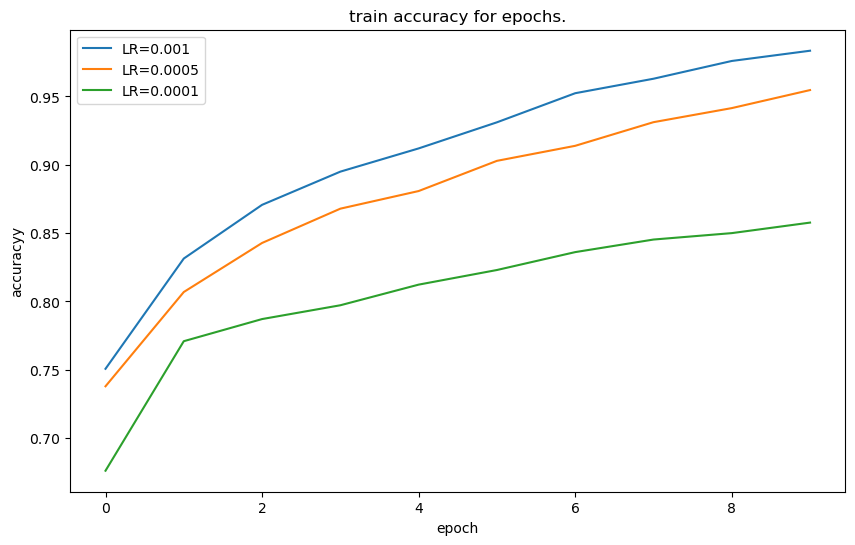

In [8]:
plt.figure(figsize=(10, 6))
for lr, acc_history in train_acc_dict.items():
    plt.plot(acc_history, label=f'LR={lr}')
plt.title('train accuracy for epochs.')
plt.xlabel('epoch')
plt.ylabel('accuracyy')
plt.legend()
plt.show()



Epoch 1, Accuracy: 0.7418
Epoch 2, Accuracy: 0.8291
Epoch 3, Accuracy: 0.8664
Epoch 4, Accuracy: 0.8967
Epoch 5, Accuracy: 0.9127
Epoch 6, Accuracy: 0.9342
Epoch 7, Accuracy: 0.9494
Epoch 8, Accuracy: 0.9671
Epoch 9, Accuracy: 0.9752
Epoch 10, Accuracy: 0.9798


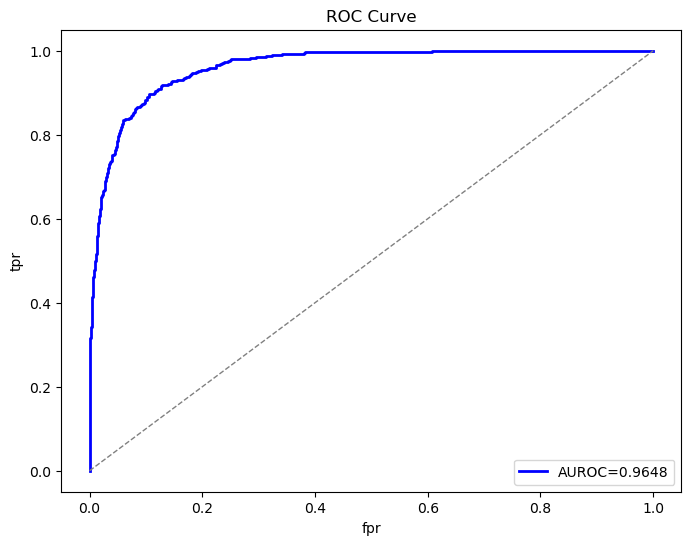

In [12]:
#plotting the roc curve now.
best_model = CNN().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
train_model(best_model, optimizer, criterion)  # Train best model

all_preds = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        all_preds.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC={auroc_dict[best_lr]:.4f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(loc='lower right')
plt.show()